#Explainer File

In [ ]:
!gdown 1vMFLRihTovCwgvJ1vGb2llrnvrzqTGDC

Downloading...
From: https://drive.google.com/uc?id=1vMFLRihTovCwgvJ1vGb2llrnvrzqTGDC
To: /content/custom_cnn_train_explainer.md
100% 2.63k/2.63k [00:00<00:00, 10.2MB/s]


#Import Libraries And Data

##Libraries

In [ ]:
%%capture
import kagglehub
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd
!pip install ipython-autotime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from collections import Counter
from tensorflow.keras import layers, models, regularizers
import random
%load_ext autotime

time: 2.21 s (started: 2025-04-18 08:18:07 +00:00)


##Data

In [ ]:
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")
!mkdir /content/dataset
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset
!mv /kaggle/input/stanford-cars-dataset/* /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists
mv: cannot stat '/root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/*': No such file or directory
mv: cannot remove '/kaggle/input/stanford-cars-dataset/cars_annos.mat': Read-only file system
mv: inter-device move failed: '/kaggle/input/stanford-cars-dataset/cars_test' to '/content/dataset/cars_test'; unable to remove target: Directory not empty
mv: inter-device move failed: '/kaggle/input/stanford-cars-dataset/cars_train' to '/content/dataset/cars_train'; unable to remove target: Directory not empty
time: 3.28 s (started: 2025-04-18 08:18:35 +00:00)


##CSV Files

In [ ]:
!gdown 1DuxsPDp4Dz-iBYZXj6xbL0f6iU9ZbIa2 -O stanford_cars_with_class_names_training.csv
!gdown 1lD1pcg7ddqo-qxGZhW6XKYJAwAbuzuPE -O stanford_cars_with_class_names_test.csv

Downloading...
From: https://drive.google.com/uc?id=1DuxsPDp4Dz-iBYZXj6xbL0f6iU9ZbIa2
To: /content/stanford_cars_with_class_names_training.csv
100% 502k/502k [00:00<00:00, 134MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lD1pcg7ddqo-qxGZhW6XKYJAwAbuzuPE
To: /content/stanford_cars_with_class_names_test.csv
100% 472k/472k [00:00<00:00, 122MB/s]
time: 8.92 s (started: 2025-04-18 08:18:52 +00:00)


#Data Processing

##Preprocessing

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
csv_train = "/content/stanford_cars_with_class_names_training.csv"
csv_test = "/content/stanford_cars_with_class_names_test.csv"

dir_train = "/content/dataset/cars_train/cars_train"
dir_test = "/content/dataset/cars_test/cars_test"

save_img_path = "/content/all_images.npy"
save_label_path = "/content/all_labels.npy"

df_train = pd.read_csv(csv_train, encoding="utf-8-sig")
df_test = pd.read_csv(csv_test, encoding="utf-8-sig")

for df in [df_train, df_test]:
    df.columns = df.columns.str.strip()
    df["image"] = df["image"].str.strip().str.replace("'", "")
    df.rename(columns={"ture_class_name": "true_class_name"}, inplace=True)
    df["class"] = df["class"] - 1

df_train["path"] = df_train["image"].apply(lambda x: os.path.join(dir_train, x))
df_test["path"] = df_test["image"].apply(lambda x: os.path.join(dir_test, x))

df_all = pd.concat([df_train, df_test], ignore_index=True)

resize_to = (320, 180)

images = np.zeros((len(df_all), resize_to[1], resize_to[0], 3), dtype=np.uint8)
labels = np.zeros(len(df_all), dtype=np.int32)

for i, row in tqdm(df_all.iterrows(), total=len(df_all)):
    try:
        with Image.open(row["path"]) as img:
            x1, y1, x2, y2 = map(int, [row["x1"], row["y1"], row["x2"], row["y2"]])
            cropped = img.crop((x1, y1, x2, y2)).convert("RGB")

            img_tensor = tf.convert_to_tensor(np.array(cropped), dtype=tf.uint8)
            padded_resized = tf.image.resize_with_pad(img_tensor, target_height=resize_to[1], target_width=resize_to[0])
            padded_resized = tf.cast(padded_resized, tf.uint8).numpy()

            images[i] = padded_resized
            labels[i] = row["class"]
    except Exception as e:
        print(f"Error processing {row['path']}: {e}")

np.save(save_img_path, images)
np.save(save_label_path, labels)

print(f"✅ Saved all images: {save_img_path}, shape: {images.shape}")
print(f"✅ Saved all labels: {save_label_path}, shape: {labels.shape}")


100%|██████████| 16185/16185 [03:26<00:00, 78.36it/s]


✅ Saved all images: /content/all_images.npy, shape: (16185, 180, 320, 3)
✅ Saved all labels: /content/all_labels.npy, shape: (16185,)
time: 3min 35s (started: 2025-04-18 08:10:21 +00:00)


##Data Split

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

images = np.load(save_img_path)
labels = np.load(save_label_path)

images = images.astype("float32") / 255.0
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=196)

X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)
print(f"✅ X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


✅ X_train shape: (12948, 180, 320, 3), y_train shape: (12948, 196)
✅ X_test shape: (3237, 180, 320, 3), y_test shape: (3237, 196)
time: 9.96 s (started: 2025-04-18 08:19:01 +00:00)


##Labels For Test

In [ ]:
y_test_int = np.argmax(y_test, axis=1) + 1
y_train_int = np.argmax(y_train, axis=1) + 1

time: 3.02 ms (started: 2025-04-18 08:19:11 +00:00)


##Data Augmentations

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.central_crop(image, central_fraction=tf.random.uniform([], 0.8, 1.0))
    image = tf.image.resize(image, [180, 320])
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

def build_dataset(X, y, batch_size=32, shuffle=True, augment_data=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(1000)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = build_dataset(X_train, y_train, augment_data=True)
val_dataset = build_dataset(X_test, y_test, shuffle=False, augment_data=False)


time: 15.9 s (started: 2025-04-18 08:19:33 +00:00)


#Global Functions

##Loss Print

In [ ]:
def plot_history(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

time: 592 µs (started: 2025-04-18 08:19:49 +00:00)


##Test

In [ ]:
def test_model(model):
  idx = random.randint(0, len(X_test) - 1)

  img = X_test[idx]
  true_label = y_test_int[idx]

  img_input = np.expand_dims(img, axis=0)

  pred_probs = model.predict(img_input)
  pred_class = np.argmax(pred_probs[0]) + 1

  plt.imshow(img)
  plt.axis("off")
  plt.title(f"Predicted: {pred_class} | True: {true_label}", fontsize=12)
  plt.show()


time: 493 µs (started: 2025-04-18 08:19:49 +00:00)


##Callbacks

In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', verbose=1)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss', verbose=1)

time: 293 µs (started: 2025-04-18 08:19:49 +00:00)


#Experiment 1

##Architecture

In [ ]:
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_custom_cnn1(input_shape=(180, 320, 3), num_classes=196):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    x = residual_block(x, 64)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 256)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 512)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model1 = build_custom_cnn1(input_shape=(180, 320, 3), num_classes=196)
model1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 90, 160,   │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 90, 160,   │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 90, 160,   │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 90, 160,   │      2,112 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 90, 160,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 90, 160,   │          0 │ add_4[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 45, 80,    │          0 │ re_lu_4[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 45, 80,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 45, 80,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 45, 80,    │      8,320 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 45, 80,    │          0 │ batch_normalizat

 Total params: 5,067,524 (19.33 MB)

 Trainable params: 5,063,620 (19.32 MB)

 Non-trainable params: 3,904 (15.25 KB)

time: 214 ms (started: 2025-04-17 21:37:08 +00:00)


##Training

In [ ]:
history1 = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.0079 - loss: 5.4632 - val_accuracy: 0.0049 - val_loss: 5.2641 - learning_rate: 1.0000e-04
Epoch 2/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0118 - loss: 5.2362 - val_accuracy: 0.0213 - val_loss: 5.1613 - learning_rate: 1.0000e-04
Epoch 3/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0137 - loss: 5.1935 - val_accuracy: 0.0195 - val_loss: 5.1208 - learning_rate: 1.0000e-04
Epoch 4/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0162 - loss: 5.1448 - val_accuracy: 0.0238 - val_loss: 5.1321 - learning_rate: 1.0000e-04
Epoch 5/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0205 - loss: 5.1152 - val_accuracy: 0.0340 - val_loss: 5.0351 - learning_rate: 1.0000e-04
Epoch 6/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0265 - loss: 5.0709 - val_accuracy: 0.0250 - val_loss: 5.0110 - learning_rate: 1.0000e-04
Epoch 7/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 2

##Loss Graph

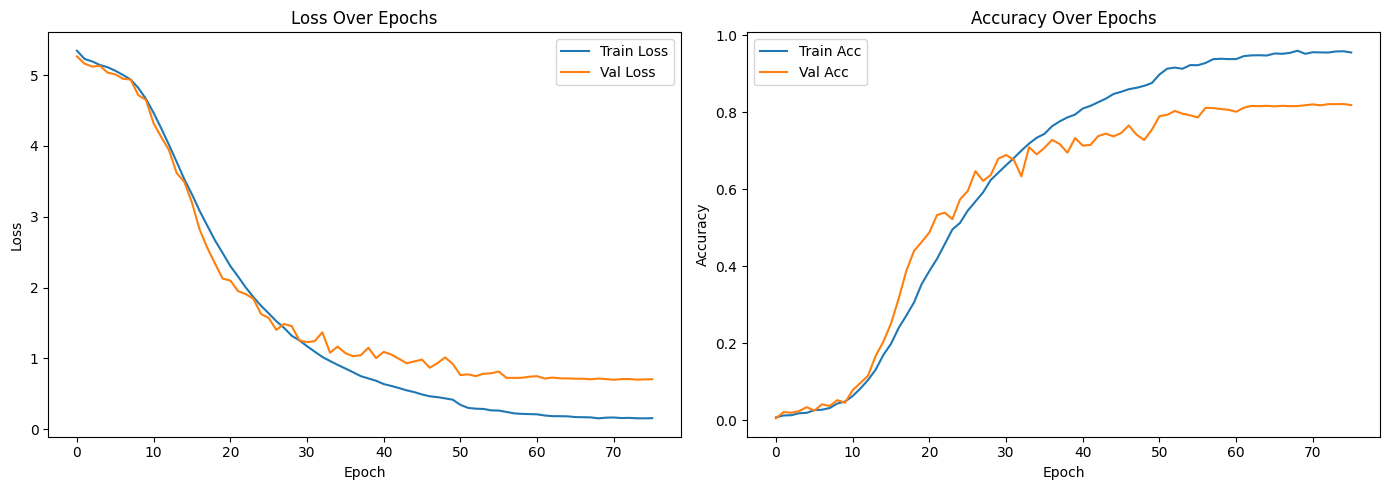

time: 308 ms (started: 2025-04-17 21:51:40 +00:00)


In [ ]:
plot_history(history1)

##Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


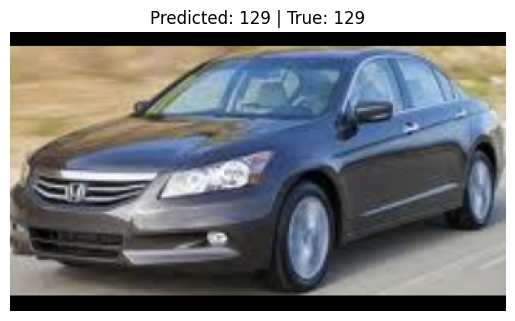

time: 205 ms (started: 2025-04-17 22:14:17 +00:00)


In [ ]:
test_model(model1)

#Experiment 2

##Architecture

In [ ]:
def residual_block_l2(x, filters, kernel_size=3, l2_weight=1e-4):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_weight))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(l2_weight))(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same',
                                 kernel_regularizer=regularizers.l2(l2_weight))(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_custom_cnn_with_l2(input_shape=(180, 320, 3), num_classes=196, l2_weight=1e-4):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(l2_weight))(inputs)
    x = layers.BatchNormalization()(x)

    x = residual_block_l2(x, 64, l2_weight=l2_weight)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block_l2(x, 128, l2_weight=l2_weight)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block_l2(x, 256, l2_weight=l2_weight)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block_l2(x, 512, l2_weight=l2_weight)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_weight))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_weight))(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model2 = build_custom_cnn_with_l2()
model2.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 160,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 160,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 90, 160,   │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 90, 160,   │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 90, 160,   │      2,112 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 90, 160,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 90, 160,   │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 80,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 45, 80,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 45, 80,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 45, 80,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 45, 80,    │          0 │ batch_normalizat

 Total params: 5,067,524 (19.33 MB)

 Trainable params: 5,063,620 (19.32 MB)

 Non-trainable params: 3,904 (15.25 KB)

time: 881 ms (started: 2025-04-18 08:20:12 +00:00)


##Training

In [ ]:
history2 = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.0064 - loss: 5.7389 - val_accuracy: 0.0083 - val_loss: 5.5452 - learning_rate: 1.0000e-04
Epoch 2/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0107 - loss: 5.5151 - val_accuracy: 0.0170 - val_loss: 5.4498 - learning_rate: 1.0000e-04
Epoch 3/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0142 - loss: 5.4642 - val_accuracy: 0.0173 - val_loss: 5.3934 - learning_rate: 1.0000e-04
Epoch 4/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0162 - loss: 5.4111 - val_accuracy: 0.0297 - val_loss: 5.3339 - learning_rate: 1.0000e-04
Epoch 5/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0213 - loss: 5.3562 - val_accuracy: 0.0309 - val_loss: 5.2822 - learning_rate: 1.0000e-04
Epoch 6/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0263 - loss: 5.2822 - val_accuracy: 0.0343 - val_loss: 5.1890 - learning_rate: 1.0000e-04
Epoch 7/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 2

##Loss Graph

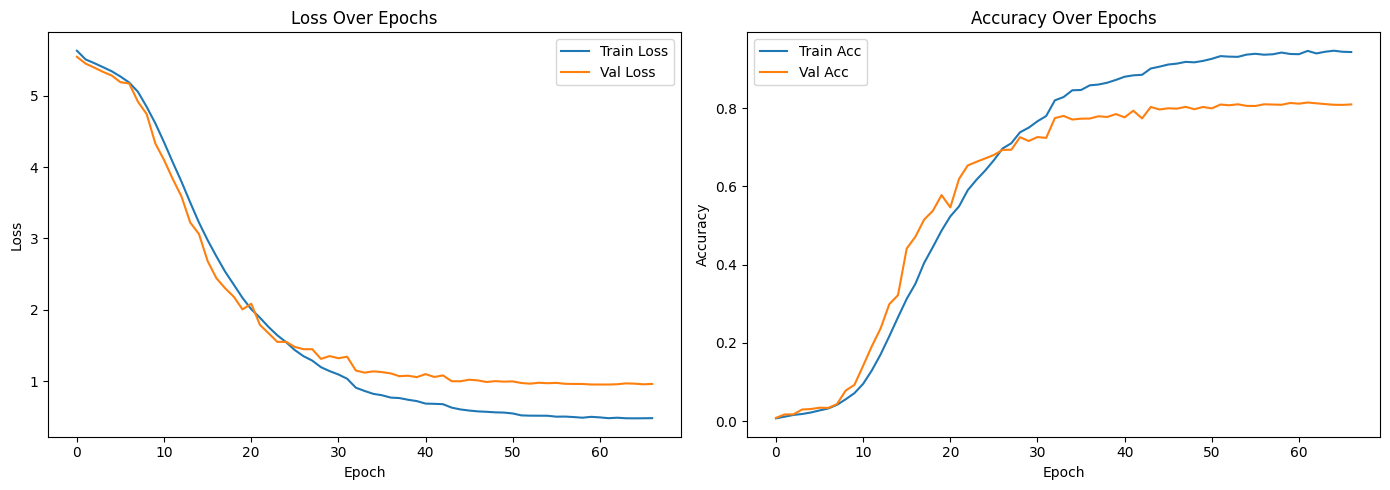

time: 304 ms (started: 2025-04-18 08:33:16 +00:00)


In [ ]:
plot_history(history2)

##Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


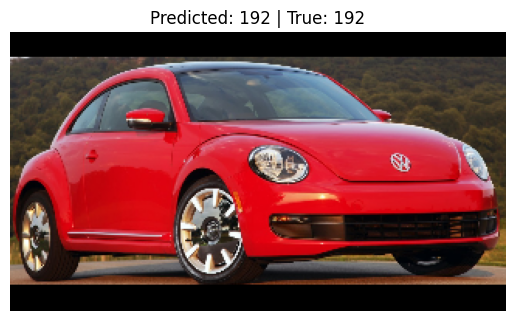

time: 214 ms (started: 2025-04-18 08:33:47 +00:00)


In [ ]:
test_model(model2)

#Experiment 3

##Atchitecture

In [ ]:
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_custom_cnn2(input_shape=(180, 320, 3), num_classes=196):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)

    x = residual_block(x, 64)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 256)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 512)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model3 = build_custom_cnn2(input_shape=(180, 320, 3), num_classes=196)
model3.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 90, 160,   │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 90, 160,   │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 90, 160,   │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 90, 160,   │      2,112 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 90, 160,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 90, 160,   │          0 │ add_4[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 45, 80,    │          0 │ re_lu_4[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 45, 80,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 45, 80,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 80,    │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 45, 80,    │      8,320 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 45, 80,    │          0 │ batch_normalizat

 Total params: 5,067,524 (19.33 MB)

 Trainable params: 5,063,620 (19.32 MB)

 Non-trainable params: 3,904 (15.25 KB)

time: 209 ms (started: 2025-04-18 08:38:30 +00:00)


##Training

In [ ]:
history3 = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.0081 - loss: 5.3503 - val_accuracy: 0.0114 - val_loss: 5.2203 - learning_rate: 0.0010
Epoch 2/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0117 - loss: 5.1882 - val_accuracy: 0.0065 - val_loss: 5.2215 - learning_rate: 0.0010
Epoch 3/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0113 - loss: 5.1590 - val_accuracy: 0.0179 - val_loss: 5.1069 - learning_rate: 0.0010
Epoch 4/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0171 - loss: 5.1242 - val_accuracy: 0.0210 - val_loss: 5.0640 - learning_rate: 0.0010
Epoch 5/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0162 - loss: 5.0639 - val_accuracy: 0.0204 - val_loss: 5.0420 - learning_rate: 0.0010
Epoch 6/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0223 - loss: 5.0085 - val_accuracy: 0.0306 - val_loss: 4.9125 - learning_rate: 0.0010
Epoch 7/150
405/405 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.0

##Loss Graph

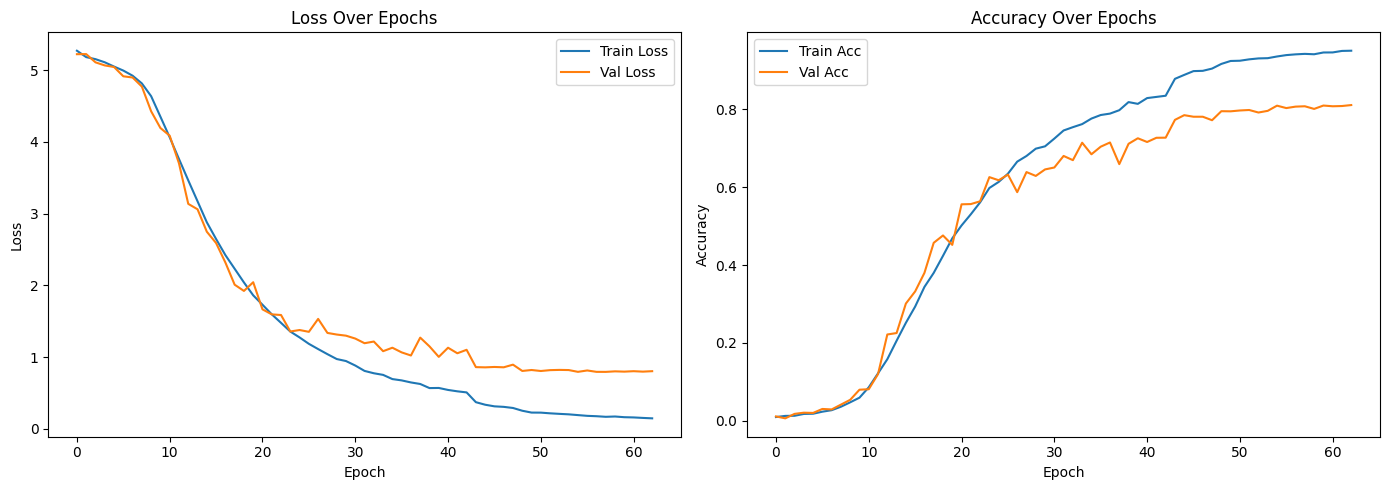

time: 285 ms (started: 2025-04-18 08:50:32 +00:00)


In [ ]:
plot_history(history3)

##Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


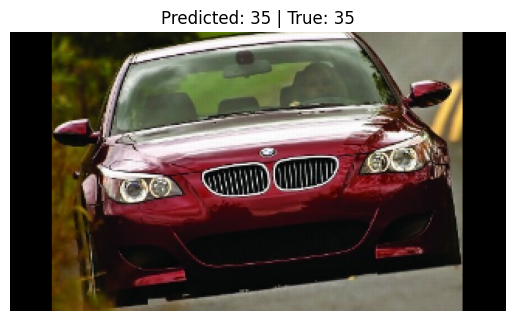

time: 210 ms (started: 2025-04-18 08:50:52 +00:00)


In [ ]:
test_model(model3)

#Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/custom_cnn_model.keras'
model3.save(model_path)
print("Model saved to:", model_path)

Mounted at /content/drive
Model saved to: /content/drive/MyDrive/custom_cnn_model.keras
time: 27.3 s (started: 2025-04-18 08:51:30 +00:00)
